# Neural Network

## 3.1 Dataloader
### What is Dataloader
Dataloader is a class that helps with shuffling and organizing the data in minibatches. We can import this class from `torch.utils.data`.

The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose the size of our minibatch to be use for training in each iteration. The constructor takes a `Dataset` object as input, along with `batch_size` and a `shuffle` boolean variable that indicates whether the data needs to be shuffled at the beginning of each epoch.

In this chapter, we are going to do classification task based on Fashion MNIST dataset. Fashion MNIST dataset could be directly imported and downloaded from `torchvision.datasets.FashionMNIST`. Pytorch has collected several datasets (CIFAR, COCO, Cityscapes, etc..) in the `torchvision` library, you may have a look of the full list of datasets at [here](https://pytorch.org/docs/stable/torchvision/datasets.html).

In [1]:
# importing the required library
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Loading/Downloading the FashionMNIST dataset, download might takes some time 
train_set = torchvision.datasets.FashionMNIST(
    root = '../data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
    )
test_set = torchvision.datasets.FashionMNIST(
    root = '../data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
    )

Loading the dataset into the `DataLoader` and input your desired batch size for training

In [3]:
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = False)

In [4]:
# A view of the DataLoader

batch = next(iter(train_loader))
images, labels = batch

# Output the size of each batch
print(images.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Each images are assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

Let us plot the image out to have a look on how does the dataset looks like.

In [5]:
# Converting numeric labels to text label

def labelsText(labels):
    labelDict = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    label = (labels.item() if type(labels) == torch.Tensor else labels)
    return labelDict[label]

Labels: 
Sandal, Sneaker, Sandal, T-shirt/Top, Bag, Sneaker, Ankle Boot, Bag, Bag, Sandal, 

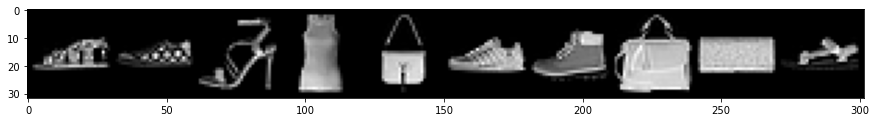

In [6]:
# Plotting out the images in the dataset

grid = torchvision.utils.make_grid(images[0:10], nrow = 10)

plt.figure(figsize = (15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print("Labels: ")
for i in labels[0:10]:
    print(labelsText(i) + ", ", end = "")

## 3.2 Build your first Neural Network

### 3.2.1 Model Training
We had loaded our dataset into training and testing set, now let us build a simple Feedfoward Neural Network to perform classification on this dataset.

PyTorch has a whole submodule dedicated to neural networks, called `torch.nn`. It contains the building blocks needed to create all sorts of neural network architectures.

To build a Neural Network, it could be done in two ways :
- Calling the `nn.Sequential()` for fast implementation of the network
- Subclassing `nn.Module` to have more flexibility on designing the network, eg: writing the your own `foward()` method


Now let us start building the Neural Network

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

We would like to build a 4 layers neural network with ReLU activation function. Apply dropout with 20% probability to reduce the effect of overfitting. Let us tryto build our model using `nn.Sequential`.

In [8]:
# nn.Sequential()
torch.manual_seed(0)
model_sequential = nn.Sequential(nn.Linear(784,256),
                                 nn.Dropout(0.2),
                                 nn.ReLU(),
                                 nn.Linear(256,128),
                                 nn.Dropout(0.2),
                                 nn.ReLU(),
                                 nn.Linear(128,64),
                                 nn.Dropout(0.2),
                                 nn.ReLU(),
                                 nn.Linear(64,10),
                                )

We will build a wrapper function for our training called `training`. This wrapper function will take on parameters:
- n_epochs
- optimizer
- model
- loss_fn
- train_loader
- writer (Instance of Summary Writer to use TensorBoard for visualization)

Pytorch does support TensorBoard which provides the visualization and tooling needed for machine learning experimentation. It is a useful tool that we can use during our training. Now let's define our training loop and implement some of the TensorBoard methods. 

If you wish to know more on TensorBoard, you can access it at [here](https://pytorch.org/docs/stable/tensorboard.html)

In [9]:
from torch.utils.tensorboard import SummaryWriter

def training(n_epochs, optimizer, model, loss_fn, train_loader, writer):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            # Clearing gradient from previous mini-batch gradient computation  
            optimizer.zero_grad()
            
            # Reshape the tensor so that it fits the dimension of our input layer
            # Get predictions output from the model
            outputs = model(imgs.view(-1, 784))
            
            # Calculate the loss for curernt batch
            loss = loss_fn(outputs, labels)
            
            # Calculating the gradient
            loss.backward()
            
            # Updating the weights and biases using optimizer.step
            optimizer.step()
            
            # Summing up the loss over each epoch
            loss_train += loss.item()
            
            # Calculating the accuracy
            predictions = torch.max(outputs, 1)[1]
            correct += (predictions == labels).sum().item()
            total += len(labels)

        accuracy = correct * 100 / total
        writer.add_scalar('Loss ', loss_train / len(train_loader), epoch)
        writer.add_scalar('Accuracy ', accuracy, epoch)
        print('Epoch {}, Training loss {} , Accuracy {:.2f} %'.format(epoch, loss_train / len(train_loader), accuracy))
    writer.close()

We can launch our TensorBoard in the terminal with the command of `tensorboard --logdir=runs`. Do remember to change to the same directory as this notebook.

Now we are ready for training. Let's use `SGD` as our optimizer and `CrossEntropy` as loss function. 

In [10]:
torch.manual_seed(0)
model_SGD = model_sequential 
optimizer = optim.SGD(model_SGD.parameters(), lr = 1e-3) 
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(comment = 'SGD')
training(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_SGD,
    loss_fn = loss_fn,
    train_loader = train_loader,
    writer = writer
)

Epoch 1, Training loss 2.2897796880086263 , Accuracy 17.98 %
Epoch 2, Training loss 2.2410062602996828 , Accuracy 28.49 %
Epoch 3, Training loss 2.0720260525385537 , Accuracy 29.49 %
Epoch 4, Training loss 1.6981404069900512 , Accuracy 36.30 %
Epoch 5, Training loss 1.4130682296117147 , Accuracy 46.62 %
Epoch 6, Training loss 1.2183696255366008 , Accuracy 52.56 %
Epoch 7, Training loss 1.1066312548955282 , Accuracy 56.30 %
Epoch 8, Training loss 1.0347878107388815 , Accuracy 59.25 %
Epoch 9, Training loss 0.980015790939331 , Accuracy 62.00 %
Epoch 10, Training loss 0.9299710073153178 , Accuracy 64.17 %


Let us build another model which we set log softmax as the activation function at the output layer and use negative log-likelihood loss function. Compare the results for both of these setting. This time we are going to build by subclassing `nn.Module`.

In [11]:
# Subclassing nn.Module
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(784, 256)
        self.act_1 = nn.ReLU()
        self.fc_2 = nn.Linear(256, 128)
        self.act_2 = nn.ReLU()
        self.fc_3 = nn.Linear(128, 64)
        self.act_3 = nn.ReLU()
        self.fc_4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.dropout(self.act_1(self.fc_1(x)))
        out = self.dropout(self.act_2(self.fc_2(out)))
        out = self.dropout(self.act_3(self.fc_3(out)))
        # adding in softmax
        out = F.log_softmax(self.fc_4(out), dim = 1)
        return out
    
# Or you can use the Pytorch provided functional API when defining the forward method. Both of these are the same.

class Classifier_F(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(784, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_3 = nn.Linear(128, 64)
        self.fc_4 = nn.Linear(64, 10)
        
    def forward(self, x):
        out = F.dropout(F.relu(self.fc_1(x)), p = 0.2)
        out = F.dropout(F.relu(self.fc_2(out)), p = 0.2)
        out = F.dropout(F.relu(self.fc_3(out)), p = 0.2)
        out = F.log_softmax(self.fc_4(out), dim = 1)
        return out

In [12]:
torch.manual_seed(0)
model_SGD = Classifier() 
optimizer = optim.SGD(model_SGD.parameters(), lr = 1e-3) 
loss_fn = nn.NLLLoss()
writer = SummaryWriter(comment = 'SGD')
training(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_SGD,
    loss_fn = loss_fn,
    train_loader = train_loader,
    writer = writer
)

Epoch 1, Training loss 2.289622783533732 , Accuracy 18.13 %
Epoch 2, Training loss 2.240501616032918 , Accuracy 28.42 %
Epoch 3, Training loss 2.070082720629374 , Accuracy 29.29 %
Epoch 4, Training loss 1.6956042586008708 , Accuracy 36.39 %
Epoch 5, Training loss 1.4084394121805828 , Accuracy 46.49 %
Epoch 6, Training loss 1.2156217664400737 , Accuracy 52.57 %
Epoch 7, Training loss 1.1035320859591167 , Accuracy 56.68 %
Epoch 8, Training loss 1.0310836893081665 , Accuracy 59.45 %
Epoch 9, Training loss 0.976319944413503 , Accuracy 62.15 %
Epoch 10, Training loss 0.9308558867772421 , Accuracy 64.06 %


CrossEntropy is actually performing log softmax and negative log-likelihood at the same time. Therefore during the construction of our model we could neglect the declaration of activation function at the output layer and save some memory during the backpropagation.

Let us try using other optimizer `Adam` to do our training. Optimizer is one of the hyperparameters that we can tune on.

In [13]:
model_Adam = Classifier() 
optimizer = optim.Adam(model_Adam.parameters(), lr = 1e-3) 
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(comment = 'Adam')
training(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_Adam,
    loss_fn = loss_fn,
    train_loader = train_loader,
    writer = writer
)

Epoch 1, Training loss 0.5975743966738383 , Accuracy 78.14 %
Epoch 2, Training loss 0.4261265473922094 , Accuracy 84.86 %
Epoch 3, Training loss 0.38790227804581323 , Accuracy 86.07 %
Epoch 4, Training loss 0.36523280014395715 , Accuracy 86.81 %
Epoch 5, Training loss 0.34695777239402137 , Accuracy 87.48 %
Epoch 6, Training loss 0.3375382266998291 , Accuracy 87.81 %
Epoch 7, Training loss 0.3244616264641285 , Accuracy 88.15 %
Epoch 8, Training loss 0.31721421119868753 , Accuracy 88.61 %
Epoch 9, Training loss 0.30821521749893827 , Accuracy 88.83 %
Epoch 10, Training loss 0.301539993061622 , Accuracy 89.00 %


In this case, we can see that `Adam` is performing better than the `SGD` with the same setting. Hyperparameter tuning is very important in order to obtain the desired result.

### 3.2.2 Model Saving
After training the model, we would like to save it for future usages. There are some pretty useful functions you might need to be familar with:

- `torch.save`: It serializes the object to save to your machine. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
- `torch.load`: This function uses pickle’s unpickling facilities to deserialize pickled object files to memory.
- `torch.nn.Module.load_state_dict`: Loads a model’s parameter dictionary using a deserialized state_dict.

If you wish to know more on model saving, you can access it at [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

#### Saving only the weights

In [14]:
import os
if not os.path.exists('../generated_model'):
    os.mkdir('../generated_model')

In [15]:
# Saving the weights only of the model
torch.save(model_Adam.state_dict(),  '../generated_model/mnist_state_dict.pt')

In [16]:
# To load the state_dict, you must have an instance of the model
modelLoad = Classifier()
modelLoad.load_state_dict(torch.load('../generated_model/mnist_state_dict.pt'))

<All keys matched successfully>

#### Saving the entire model

In [17]:
# Saving the entire model
torch.save(model_Adam, '../generated_model/mnist_model.pt')

In [18]:
# Loading model
modelLoad = torch.load('../generated_model/mnist_model.pt')

### Add-ons: Saving Model in ONNX format
Pytorch also support saving model as ONNX (Open Neural Network Exchange) file type, which is a open format built to represent machine learning models. Let's see how to do it.

In [19]:
import torch.onnx 
dummy_input = torch.randn(32, 784, requires_grad = True)
torch.onnx.export(model_Adam, dummy_input, '../generated_model/model.onnx', verbose = True, input_names = ['input'], output_names = ['output'])

graph(%input : Float(32:784, 784:1, requires_grad=1, device=cpu),
      %fc_1.weight : Float(256:784, 784:1, requires_grad=1, device=cpu),
      %fc_1.bias : Float(256:1, requires_grad=1, device=cpu),
      %fc_2.weight : Float(128:256, 256:1, requires_grad=1, device=cpu),
      %fc_2.bias : Float(128:1, requires_grad=1, device=cpu),
      %fc_3.weight : Float(64:128, 128:1, requires_grad=1, device=cpu),
      %fc_3.bias : Float(64:1, requires_grad=1, device=cpu),
      %fc_4.weight : Float(10:64, 64:1, requires_grad=1, device=cpu),
      %fc_4.bias : Float(10:1, requires_grad=1, device=cpu)):
  %9 : Float(32:256, 256:1, requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%input, %fc_1.weight, %fc_1.bias) # C:\Users\GuanSheng.Wong\anaconda3\envs\sansiaolaa\lib\site-packages\torch\nn\functional.py:1690:0
  %10 : Float(32:256, 256:1, requires_grad=1, device=cpu) = onnx::Relu(%9) # C:\Users\GuanSheng.Wong\anaconda3\envs\sansiaolaa\lib\site-packages\torch\nn\functional.p

In [20]:
import onnx
#loading the onnx format model
model = onnx.load('../generated_model/model.onnx')

### 3.2.3 Inference
Sometimes, we would like to inference on the trained model to evaluate the performance. `model.eval()` will set the model to evaluation(inference) mode to set dropout, batch normalization layers, etc.. to evaluation mode. Evaluation mode will disable the usage of dropout and batch normalization during the `foward` method as it is not required during the inference.

In [21]:
# Using previous loaded model
modelLoad.eval()           

Classifier(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (act_1): ReLU()
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (act_2): ReLU()
  (fc_3): Linear(in_features=128, out_features=64, bias=True)
  (act_3): ReLU()
  (fc_4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

After setting it to inference mode, we could pass in test data with the setting of 
```python 
with torch.no_grad():
``` 
as we do not have to calculate the gradient during the inference, this can help us save some memory.

In [22]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = modelLoad(images.view(-1, 784))
        predictions = torch.max(outputs, 1)[1]
        correct += (predictions == labels).sum()
        total += len(labels)
    accuracy_test = correct.item() * 100 / total
print("Test Accuracy : {:.2f} %".format(accuracy_test))

Test Accuracy : 87.79 %


## 3.3 Build your second Neural Network
### 3.3.1 Model Training

Altough there are many other machine learning techniques to tackle multi-variate linear regression, it would be interesting for us to tackle it using deep learning for learning purposes.
<br>In this sub-section, we will try to perform said regression using PyTorch `SequentialModel` 

We will use the Real Estate dataset from the `realEstate.csv` for our linear regression example. 

Description of data:
- House Age
- Distance from the unit to MRT station
- The number of Convenience Stores around the unit
- House Unit Price per 1000 USD

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

First we use pandas to load in the csv.<br>
Note that in this dataset there are a total of $3$ features and $1$ label.<br>
Thus from the data we will use `.iloc[]` to distinguish the features and labels.

In [24]:
data = pd.read_csv("../data/Regression/realEstate.csv", header = 0)
n_features = 3
X = data.iloc[:, 0:3].values
y = data.iloc[:, 3].values

Following that, we split our dataset into 70/30 train/test ratio.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1022)

Next, we perform feature scaling onto `X_train` and `X_test` using `StandardScaler` from `scikit-learn`.<br>
*Note: only fit the train_set but transform both train and test sets*

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In section 3.1, we've touch on how Dataloaders are initialized and used in model training. It was simple, which is to pass in whatever `Dataset` we need into the Dataloader initializer. <br>

Here, we are using a custom dataset from a csv file as compared to the previous one which was prepared readily from torchvision. Thus in this case, we will have to build our own by subclassing from `torch.utils.data.Dataset`.

Whilst subclassing `Dataset`, PyTorch [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) notes that we have to override the `__getitem__()` method and optionally the `__len__()` method.<br>
We will mainly have three methods in this `Dataset` class:
- `__init__(self, data, label)`: helps us pass in the feature and labels into the dataset
- `__len__(self)`:allows the dataset to know how many instances of data there is 
- `__getitem__(self, idx)`:allows the dataset to get items from the data and labels by indexing

In [27]:
class Custom_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype  = torch.float32)

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

After feature scaling, we initialize our custom datasets and put them into `Dataloader` constructor and our data is prepared. The next step will be modeling.

In [28]:
train_dataset = Custom_Dataset(X_train, y_train)
test_dataset = Custom_Dataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 128 )

Like we previously stated, there are two approaches of modeling.
- Subclassing `nn.Module` 
- Calling the `nn.Sequential()` 

`torch.nn.Sequential` is a simple function that accepts a list of `nn.Modules` and returns a model with all the sequential layers. We will be implementing these few layers:
1. nn.Linear(3,50)
2. nn.ReLU()
3. nn.Linear(50,25)
4. nn.ReLU()
5. nn.Linear(25,10)
6. nn.ReLU()
7. nn.Linear(10,1)

In [29]:
torch.manual_seed(123)
model_sequential = nn.Sequential(nn.Linear(n_features, 50),
                                 nn.ReLU(),
                                 nn.Linear(50, 25),
                                 nn.ReLU(),
                                 nn.Linear(25, 10),
                                 nn.ReLU(),
                                 nn.Linear(10, 1)
                                 )

For this regression probelm, the loss/criterion we will use is Mean-Squared-Error loss, which in PyTorch is `nn.MSELoss()`<br>
We will also choose `Adam` as our optimizer.<br> Remember, `torch.optim.*any_optimizer*` accepts `model.parameters()` to keep track of the model's parameters, hence we should always initialize our model first before our optimizer.

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_sequential.parameters(), lr = 0.01)

Now that our modeling is done, let's commence our training with using the training loop that defined previously

We will build a wrapper function for our training called `train_model`. This wrapper function will take on parameters:
- model
- loader
- loss_function/criterion
- optimizer
- number_of_epochs (optional)
- iteration_check (optional): *if False is passed in, losses of each iteration per epoch will not be printed>*

Below will be an overall workings an explaination of our train_model function:
1. In each epoch, each minibatch starts with `optimizer.zero_grad()`. This is to clear previously computed gradients from previous minibatches.
2. We get the features and labels by indexing our minibatch.
3. Compute forward propagation by calling `model(features)` and assigning it to a variable `prediction`
4. Compute the loss by calling `criterion(prediction, torch.unsqueeze(labels, dim=1))`
    - the reason we unsqueeze is to make sure the shape of the labels are the same as the predictions, which is (batch_size,1) 
5. Compute backward propagation by calling `loss.backward()`
6. Update the parameters(learning rate etc.) of the model by calling `optimizer.step()`
7. Increment our `running_loss` with the loss of our current batch
8. At the end of each epoch, compute the accuracy by dividing the accumulated loss and the amount of data samples, and finally reset the `running_loss` for the next epoch.


In [31]:
def train_model(model, loader, criterion, optimizer,epochs=5000):
#   this running_loss will keep track of the losses of every epoch from each respective iteration
    running_loss = 0.0
    for epoch in range(1, epochs + 1):
        for i, data in enumerate(loader):
#           zero the parameter gradients
            optimizer.zero_grad()
            features, labels = data[0],data[1]
            prediction = model(features)
            loss = criterion(prediction, torch.unsqueeze(labels,dim=1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch % 100 == 0 or epoch == 1):
            print(f"Epoch {epoch} Loss: {running_loss / len(loader)}")     
        running_loss = 0.0

In [32]:
torch.manual_seed(0)
train_model(model_sequential, train_loader, criterion, optimizer)

Epoch 1 Loss: 1559.3144104003907
Epoch 100 Loss: 61.67083263099194
Epoch 200 Loss: 57.539203613996506
Epoch 300 Loss: 54.59025017023087
Epoch 400 Loss: 51.96991606549127
Epoch 500 Loss: 48.42132487297058
Epoch 600 Loss: 47.82911126613617
Epoch 700 Loss: 46.05727748870849
Epoch 800 Loss: 44.36096715927124
Epoch 900 Loss: 43.9363185852766
Epoch 1000 Loss: 42.44988851547241
Epoch 1100 Loss: 39.48572450876236
Epoch 1200 Loss: 40.400172993540764
Epoch 1300 Loss: 37.36015833616257
Epoch 1400 Loss: 39.51378511190414
Epoch 1500 Loss: 39.25860457122326
Epoch 1600 Loss: 36.81818242222071
Epoch 1700 Loss: 36.8226953625679
Epoch 1800 Loss: 41.02889460325241
Epoch 1900 Loss: 37.985161542892456
Epoch 2000 Loss: 31.60232810974121
Epoch 2100 Loss: 30.642181020975112
Epoch 2200 Loss: 29.302261823415755
Epoch 2300 Loss: 30.363357257843017
Epoch 2400 Loss: 24.800373206473886
Epoch 2500 Loss: 21.449703025817872
Epoch 2600 Loss: 18.494161200523376
Epoch 2700 Loss: 23.868587064743043
Epoch 2800 Loss: 23.203

### 3.3.2 Inference

Now let's evaluate our model. Use `model.eval()` to set the model to inference mode

In [33]:
model_sequential.eval()

Sequential(
  (0): Linear(in_features=3, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

Let's say your house age is 10, distance to MRT is 100 meters, and there are 6 convenience stores around the unit, could you predict your house price? Let's use our trained model to find out

In [34]:
with torch.no_grad():
    inference = torch.tensor([[10, 100, 6]])
    inference = torch.from_numpy(scaler.transform(inference))
    predict = model_sequential.forward(inference.float())
        
print("The prediction for your house price is :", predict.item() * 1000)

The prediction for your house price is : 86658.43200683594


# Exercise

In this exercise we will try to build a classifier for our MNIST Handwriting dataset.

Construct transform with the following transforms:
- coverting to tensor
- normalize the tensor with mean=0.15 and std=0.3081

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.15,), (0.3081,))]
)

Obtain the MNIST dataset from `torchvision.datasets`. Load them into respective `Dataloaders`

In [36]:
from torchvision.datasets import MNIST

train = MNIST("../data", download = True, transform = transform, train = True)
test = MNIST("../data", download = True, transform = transform, train = False)

In [37]:
train_loader = DataLoader(train, 100, shuffle = True, num_workers = 0)
test_loader = DataLoader(test, 100, shuffle = False, num_workers = 0)

Declare `SummaryWriter` for TensorBoard

In [38]:
writer = SummaryWriter()

Create a Model with the following layers:
- 4 linear/dense layers
- First 3 with ReLU activation functions

*Note: Remember to resize the incoming tensor first*

In [39]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features = 28 * 28, out_features = 1000)
        self.fc2 = nn.Linear(in_features = 1000, out_features = 500)
        self.fc3 = nn.Linear(in_features = 500, out_features = 100)
        self.fc4 = nn.Linear(in_features = 100, out_features = 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Initialize the model and load it to our **GPU**.

In [40]:
model = Model()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.to(device)

Initialize criterion: `CrossEntropyLoss` and optimizer `Adam`.

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Build a wrapper function `train_model` to train the model using `CUDA`. `add_scalar` which shows a loss against epoch graph on TensorBoard.<br>
Here is a checklist for you to keep check what to do:
1. For each iteration in each epoch, zero the gradients of the parameters
2. Forward propagate
3. Calculate loss
4. Write the loss and train to TensorBoard
5. Back propagate
6. Update the parameters
7. For each epoch, calculate the accuracy on our test set

In [42]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs = 5):
    accuraccy_list = []
    for epoch in range(epochs):
        total = 0
        correct = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
            if i % 50 == 0:
                print(f'Epoch:{epoch + 1} \nIteration:{i} \nLoss:{loss}')
            with torch.no_grad():
                total += labels.size(0)
                _,prediction = torch.max(outputs, 1)
                correct += (prediction == labels).sum().item()
        print(f'\nAccuracy of network in epoch {epoch + 1}: {100 * correct / total}')
    writer.flush()

train_model(model, train_loader, test_loader, criterion, optimizer)
writer.close()

Epoch:1 
Iteration:0 
Loss:2.3132412433624268
Epoch:1 
Iteration:50 
Loss:0.2587825655937195
Epoch:1 
Iteration:100 
Loss:0.1759798377752304
Epoch:1 
Iteration:150 
Loss:0.5320650935173035
Epoch:1 
Iteration:200 
Loss:0.11219176650047302
Epoch:1 
Iteration:250 
Loss:0.21292977035045624
Epoch:1 
Iteration:300 
Loss:0.06624757498502731
Epoch:1 
Iteration:350 
Loss:0.23068048059940338
Epoch:1 
Iteration:400 
Loss:0.1354784369468689
Epoch:1 
Iteration:450 
Loss:0.1977384388446808
Epoch:1 
Iteration:500 
Loss:0.21918486058712006
Epoch:1 
Iteration:550 
Loss:0.142175555229187

Accuracy of network in epoch 1: 93.09
Epoch:2 
Iteration:0 
Loss:0.06362845003604889
Epoch:2 
Iteration:50 
Loss:0.05630754306912422
Epoch:2 
Iteration:100 
Loss:0.08950706571340561
Epoch:2 
Iteration:150 
Loss:0.14282292127609253
Epoch:2 
Iteration:200 
Loss:0.1496964693069458
Epoch:2 
Iteration:250 
Loss:0.09983617067337036
Epoch:2 
Iteration:300 
Loss:0.08513499051332474
Epoch:2 
Iteration:350 
Loss:0.02917087078094

In [43]:
total = 0
correct = 0
for data, labels in test_loader:
    data = data.to(torch.device("cuda:0"))
    with torch.no_grad():
        validation = model(data)
        _,prediction = torch.max(validation, 1)
        total += labels.size(0)
        correct += (prediction.cpu() == labels).sum().item()
    
print(f'Accuracy of the network:{100 * correct / total}')

Accuracy of the network:97.84
